<h2 style="color:blue" align="center">Plain Deep Neural Network (DNN) on CIFAR</h2>

#### Import the necessary libraries

In [1]:
import tensorflow as tf 
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time, math 

from tensorflow import keras 
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.callbacks import Callback, CSVLogger 

#### Load and split the dataset into training and testing set

CIFAR 10

In [2]:
(X_train,y_train),(X_test,y_test) = keras.datasets.cifar10.load_data()

CIFAR 100

In [3]:
#(X_train,y_train),(X_test,y_test) = keras.datasets.cifar100.load_data()

Here we see there are 50000 training images and 1000 test images

In [4]:
X_test.shape

(10000, 32, 32, 3)

In [5]:
y_train.shape

(50000, 1)

In [6]:
y_train[:5]

array([[6],
       [9],
       [9],
       [4],
       [1]], dtype=uint8)

y_train is a 2D array, for our classification having 1D array is good enough. so we will convert this to now 1D array

In [7]:
y_train = y_train.reshape(-1,)
y_train[:5]

array([6, 9, 9, 4, 1], dtype=uint8)

In [8]:
y_test = y_test.reshape(-1,)

In [9]:
classes = ["airplane","automobile","bird","cat","deer","dog","frog","horse","ship","truck"]

Let's plot some images to see what they are

In [10]:
def plot_sample(X, y, index):
    plt.figure(figsize = (15,2))
    plt.imshow(X[index])
    plt.xlabel(classes[y[index]])

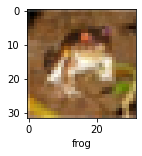

In [11]:
plot_sample(X_train, y_train, 0)

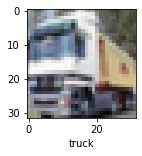

In [12]:
plot_sample(X_train, y_train, 1)

#### Normalize the input dataset

Normalize the images to a number from 0 to 1. Image has 3 channels (R,G,B) and each value in the channel can range from 0 to 255. Hence to normalize in 0-->1 range, we need to divide it by 255

In [13]:
X_train_normalized = X_train / 255.0
X_test_normalized = X_test / 255.0

In [14]:
y_train = y_train.reshape(-1,)
y_test = y_test.reshape(-1,)

#### Define DNN model

In [15]:
import random as python_random
python_random.seed(3)
np.random.seed(7)
tf.random.set_seed(13)

def get_model(): 
    model = Sequential([ 
          Flatten(input_shape=(32,32,3)),
          Dense(3000, activation = 'relu'),
          Dense(1000, activation = 'relu'),
          Dense(10, activation = 'softmax')
    ]) 
    
    # General SGD
    #opti = keras.optimizers.SGD(learning_rate=0.01)
    
    # SGD with momentum
    #opti = keras.optimizers.SGD(learning_rate=0.01, momentum=0.6)
    
    # SGD with Nesterov momentum 
    #opti = keras.optimizers.SGD(learning_rate=0.01, momentum=0.6, nesterov=True)
    
    # RMSprop 
    #opti = keras.optimizers.RMSprop(learning_rate=0.001, momentum=0.6)
    
    # Adam
    opti = keras.optimizers.Adam(learning_rate=0.001) 
    
    # Adamax
    #opti = keras.optimizers.Adamax(learning_rate=0.001) 
    
    model.compile(
        optimizer = opti,
        loss = 'sparse_categorical_crossentropy',
        metrics = ['accuracy']
    )
    
    return model

#### Custom callbacks

For generic optimizer model

In [16]:
class CustomCallbackGeneric(Callback):  
    # Training stop criteria
    stop_at = 0.99
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')> self.stop_at):  
            self.model.stop_training = True

For HM based optimizer model

In [17]:
class CustomCallbackHM(Callback):  
    # Stop the algorithm when the following accuracy reached 
    stop_at = 0.995  
    
    initial_weights = 0
    previous_weights = 0
    call_hm = 0 
     
    def on_train_begin(self, logs=None):
        self.initial_weights = model_hm.get_weights() 
        self.initial_weights = np.array(self.initial_weights,dtype=object)
        self.previous_weights = self.initial_weights
        # Harmonic mean based weights calculation
        self.call_hm = np.vectorize(self.apply_hm)  

    def on_epoch_end(self, epoch, logs={}):
        # Training stop criteria
        if(logs.get('accuracy')> self.stop_at):  
            self.model.stop_training = True
        
        num_layers = len(model_hm.layers)-1  
        current_weights = model_hm.get_weights() 
        current_weights = np.array(current_weights, dtype=object)       

        for i in range(num_layers):  
            # Harmonic mean based weights calculation 
            tensor1 = tf.convert_to_tensor(self.previous_weights[i*2])
            tensor2 = tf.convert_to_tensor(current_weights[i*2])
            current_weights[i*2] = self.call_hm(tensor1, tensor2)   
               
        # Updating the model with new weights   
        model_hm.set_weights(current_weights.tolist())
        self.previous_weights = current_weights
        
    def apply_hm(self, v1, v2):     
        if v1==0 or v2==0:
            return v2
        elif v1>0 and v2>0:
            hm = 2*v1*v2/(v1+v2)
            min1 = min(v1,v2)
            diff = abs(hm-min1)
            if v2 > v1:
                return v2 + diff
            else:
                return v2 - diff
        elif v1<0 and v2<0:
            hm = 2*v1*v2/(v1+v2)
            max1 = max(v1,v2)
            diff = abs(hm-max1)
            if v2 > v1:
                return v2 + diff
            else:
                return v2 - diff
        else:
            return v2  

To record loss and accuracy in CSV file

In [18]:
logger_generic_model = CSVLogger('Generic_model_CIFAR.csv', append=False, separator=',')
logger_hm_model = CSVLogger('HM_model_CIFAR.csv', append=False, separator=',')

#### Training

Get a model to assign same weights to model with and without HM

In [26]:
model = get_model() 
weights = model.get_weights() 
model_wihtout_hm = get_model()
model_wihtout_hm.set_weights(weights) 
model_hm = get_model()
model_hm.set_weights(weights) 

Generic opimizer model

In [27]:
st = time.time()
model_wihtout_hm.fit(X_train_normalized, y_train, epochs = 5, verbose=1, callbacks=[CustomCallbackGeneric(), logger_generic_model], batch_size = X_train.shape[0]) 
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Epoch 1/5
1/1 [==============================] - 14s 14s/step - loss: 2.3701 - accuracy: 0.0997
Epoch 2/5
1/1 [==============================] - 11s 11s/step - loss: 15.6262 - accuracy: 0.1000
Epoch 3/5
1/1 [==============================] - 11s 11s/step - loss: 14.1838 - accuracy: 0.1000
Epoch 4/5
1/1 [==============================] - 11s 11s/step - loss: 14.3863 - accuracy: 0.1000
Epoch 5/5
1/1 [==============================] - 12s 12s/step - loss: 11.4213 - accuracy: 0.1483
Execution time: 58.968225955963135 seconds


HM based optimizer model

In [28]:
st = time.time()
model_hm.fit(X_train_normalized, y_train, epochs = 5, verbose=1, callbacks=[CustomCallbackHM(),logger_hm_model], batch_size = X_train.shape[0]) 
et = time.time()
elapsed_time = et - st
print('Execution time:', elapsed_time, 'seconds')

Epoch 1/5
1/1 [==============================] - 23s 23s/step - loss: 2.3701 - accuracy: 0.0997
Epoch 2/5
1/1 [==============================] - 20s 20s/step - loss: 28.1843 - accuracy: 0.1000
Epoch 3/5
1/1 [==============================] - 20s 20s/step - loss: 23.6516 - accuracy: 0.1000
Epoch 4/5
1/1 [==============================] - 20s 20s/step - loss: 22.3825 - accuracy: 0.1000
Epoch 5/5
1/1 [==============================] - 20s 20s/step - loss: 14.9316 - accuracy: 0.1000
Execution time: 103.59983706474304 seconds


Model summary

In [23]:
model_hm.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3072)              0         
                                                                 
 dense_6 (Dense)             (None, 3000)              9219000   
                                                                 
 dense_7 (Dense)             (None, 1000)              3001000   
                                                                 
 dense_8 (Dense)             (None, 10)                10010     
                                                                 
Total params: 12,230,010
Trainable params: 12,230,010
Non-trainable params: 0
_________________________________________________________________


###### Testing the model

Generic opimizer model

In [29]:
model_wihtout_hm.evaluate(X_test_normalized, y_test)

313/313 [==============================] - 3s 10ms/step - loss: 10.4297 - accuracy: 0.1000


[10.429657936096191, 0.10000000149011612]

HM based optimizer model

In [30]:
model_hm.evaluate(X_test_normalized, y_test)

313/313 [==============================] - 3s 10ms/step - loss: 14.5787 - accuracy: 0.1000


[14.578675270080566, 0.10000000149011612]